```
[pre-works]
```
compare with open source code of [cheind](https://github.com/cheind/mingru)
to check my code

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 128

EMBEDDING_DIM = SEQUENCE_LENGTH
HIDDEN_DIM = EMBEDDING_DIM*2

BATCH_SIZE = 512
EPOCHS = 10
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1

NUM_LAYERS = 3
NUM_HEADS = 4
FFN_DIM = SEQUENCE_LENGTH
DROPOUT = 0.1

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:1


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('../data/input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003727
Validation dataset size: 111411


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([512, 128])
Target shape: torch.Size([512, 128])
Sample 1: ------------------------------
Input sequence : uin seven hurts i' the body.MENENIUS:One i' the neck, and two i' the thigh,--there'snine that I know.VOLUMNIA:He had, bef
Target sequence: in seven hurts i' the body.MENENIUS:One i' the neck, and two i' the thigh,--there'snine that I know.VOLUMNIA:He had, befo

Sample 2: ------------------------------
Input sequence : ress this garden,How dares thy harsh rude tongue sound this unpleasing news?What Eve, what serpent, hath suggested theeTo mak
Target sequence: ess this garden,How dares thy harsh rude tongue sound this unpleasing news?What Eve, what serpent, hath suggested theeTo make

Sample 3: ------------------------------
Input sequence : nd of currants, rice,--what willthis sister of mine do with rice? But my fatherhath made her mistress of the feast, and she la
Target sequence: d of currants, rice,--what willthis sister of mine do with rice? But my fathe

## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = []
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # Training phase with tqdm updates
        epoch_train_losses, step, vram_usage = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses)
        all_vram_usages.append(vram_usage)
        
        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, Epoch Time: {epoch_time:.2f}s',
              f'Average Vram Usage: {np.mean(vram_usage):.2f}MB')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    # average_vram_usage = np.mean(all_vram_usages)
    return model, train_losses_df, val_losses_df


In [13]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [14]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [15]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [16]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [17]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [18]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])

In [19]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

In [20]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [21]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, fused=True)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

## mingru

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math # math.log 및 상수 사용을 위함
from tqdm import tqdm # tqdm 임포트 추가

# Lion 옵티마이저 임포트 (설치 필요: pip install lion-pytorch)
# from lion_pytorch import Lion # 주석 처리 - 실제 사용 시 주석 해제

def log_g(x: torch.Tensor) -> torch.Tensor:
    """
    은닉 상태 후보를 로그 공간으로 변환하는 함수.
    x >= 0 이면 log(x + 0.5)
    x < 0 이면 log(sigmoid(x))
    """
    return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))

def parallel_scan_log(log_coeffs: torch.Tensor, log_values: torch.Tensor) -> torch.Tensor:
    """
    로그 공간에서 병렬 스캔 연산을 수행합니다. (클램핑 제거됨)
    Args:
        log_coeffs (torch.Tensor): [B, L, H_internal] 형태의 텐서로, log(alpha_t)를 나타냅니다.
        log_values (torch.Tensor): [B, L+1, H_internal] 형태의 텐서로, [log_h_initial, log(beta_1), ..., log(beta_L)]를 나타냅니다.
    Returns:
        torch.Tensor: [B, L, H_internal] 형태의 텐서로, 지수 함수가 적용된 은닉 상태 (h_1 부터 h_L까지)를 나타냅니다.
    """
    log_proda_coeffs_prefix = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0), value=0.0)
    terms_for_logcumsumexp = log_values - log_proda_coeffs_prefix
    log_sum_exp_terms = torch.logcumsumexp(terms_for_logcumsumexp, dim=1) 
    log_hidden_states = log_proda_coeffs_prefix + log_sum_exp_terms
    output_hidden_states = torch.exp(log_hidden_states[:, 1:, :]) 
    return output_hidden_states

class ParallelLogMinGRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, expansion_factor: float = 1.0, epsilon: float = 1e-7):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.expansion_factor = expansion_factor # GRU 셀 내부의 확장 계수
        # GRU 셀 내부에서 사용될 확장된 차원 (hidden_size는 이 셀의 기본 출력 차원을 의미)
        self.internal_expanded_dim = int(hidden_size * self.expansion_factor)
        self.epsilon = epsilon

        # 입력 input_size를 internal_expanded_dim * 2 (은닉 상태 후보용, 게이트용)로 프로젝션
        self.to_hidden_and_gate = nn.Linear(input_size, self.internal_expanded_dim * 2)
        
        # GRU 셀 내부 확장이 있었다면, 다시 hidden_size로 프로젝션
        if self.expansion_factor != 1.0:
            self.to_out = nn.Linear(self.internal_expanded_dim, hidden_size)
        else:
            self.to_out = nn.Identity()
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'linear' in name or 'to_hidden_and_gate' in name or 'to_out' in name :
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name and param is not None: # bias가 있을 경우에만 초기화
                    nn.init.zeros_(param)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, L, input_size]
        B, L, _ = x.size()
        hidden_and_gate = self.to_hidden_and_gate(x) # [B, L, internal_expanded_dim * 2]
        h_candidate_input_expanded, logits_z_expanded = hidden_and_gate.chunk(2, dim=-1) # 각각 [B, L, internal_expanded_dim]
        
        log_A = F.logsigmoid(-logits_z_expanded)
        log_Z_expanded = F.logsigmoid(logits_z_expanded)
        log_h_candidate_contrib_expanded = log_g(h_candidate_input_expanded)
        log_B = log_Z_expanded + log_h_candidate_contrib_expanded

        log_h0_val = torch.full((B, 1, self.internal_expanded_dim),
                                math.log(self.epsilon),
                                device=x.device, dtype=x.dtype)
        log_vals = torch.cat([log_h0_val, log_B], dim=1) # [B, L+1, internal_expanded_dim]
        h_expanded_scan_out = parallel_scan_log(log_A, log_vals) # [B, L, internal_expanded_dim]
        
        output = self.to_out(h_expanded_scan_out) # [B, L, hidden_size]
        return output

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        variance = x.pow(2).mean(dim=-1, keepdim=True)
        return x * torch.rsqrt(variance + self.eps) * self.gamma

class CausalDepthWiseConv1d(nn.Module):
    def __init__(self, dim: int, kernel_size: int):
        super().__init__()
        self.kernel_size = kernel_size
        self.net = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim), 
            nn.Conv1d(dim, dim, kernel_size=1)                       
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_orig_shape = x.shape
        # x.ndim 대신 len(x.shape) 또는 x.dim() 사용
        if x.dim() == 2: 
            x = x.unsqueeze(0) 
        x_transposed = x.transpose(1, 2) 
        x_padded = F.pad(x_transposed, (self.kernel_size - 1, 0), value=0.)
        x_conv_out = self.net(x_padded)
        x_restored = x_conv_out.transpose(1, 2) 
        # len(x_orig_shape) 사용
        if len(x_orig_shape) == 2 and x_restored.shape[0] == 1:
            x_restored = x_restored.squeeze(0) 
        return x_restored

class SwiGLUFFN(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 4.0, dropout: float = 0.1):
        super().__init__()
        ffn_hidden_dim = int(dim * expansion_factor)
        
        self.w1_w3 = nn.Linear(dim, ffn_hidden_dim * 2, bias=False) 
        self.w2 = nn.Linear(ffn_hidden_dim, dim, bias=False)       
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_proj = self.w1_w3(x)
        x1, x3_gate = x_proj.chunk(2, dim=-1) 
        hidden_states = F.silu(x1) * x3_gate
        hidden_states = self.dropout(hidden_states) 
        return self.w2(hidden_states)

class MinGRUDecoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int = 2,
        dropout: float = 0.1, 
        expansion_factor_gru: float = 1.0, 
        epsilon_gru: float = 1e-7,
        rms_norm_eps: float = 1e-8,
        enable_conv: bool = True, 
        conv_kernel_size: int = 3, 
        ffn_expansion_factor: float = 1.0 
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.input_projection = nn.Linear(embedding_dim, hidden_dim) if embedding_dim != hidden_dim else nn.Identity()
        
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            ffn_layer = SwiGLUFFN(
                dim=hidden_dim, 
                expansion_factor=ffn_expansion_factor, 
                dropout=dropout 
            )

            self.layers.append(nn.ModuleList([
                CausalDepthWiseConv1d(hidden_dim, conv_kernel_size) if enable_conv else nn.Identity(), 
                RMSNorm(hidden_dim, eps=rms_norm_eps),                                                 
                ParallelLogMinGRU(
                    input_size=hidden_dim, 
                    hidden_size=hidden_dim, 
                    expansion_factor=expansion_factor_gru, 
                    epsilon=epsilon_gru
                ),                                                                                     
                RMSNorm(hidden_dim, eps=rms_norm_eps),                                                 
                ffn_layer,                                                                             
                nn.Dropout(dropout) if dropout > 0. else nn.Identity()                                 
            ]))

        self.final_norm = RMSNorm(hidden_dim, eps=rms_norm_eps) 
        self.output_fc1 = nn.Linear(hidden_dim, hidden_dim * 4) 
        self.output_fc2 = nn.Linear(hidden_dim * 4, vocab_size)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, None]:
        h = self.embedding(x)
        h = self.input_projection(h)

        for block_idx, block_modules in enumerate(self.layers):
            conv_layer, norm_gru_input, gru_cell, norm_ff_input, ffn_module, dropout_block_output = block_modules

            h_conv_input = h
            if not isinstance(conv_layer, nn.Identity): 
                h_conv_out = conv_layer(h)
                h = h_conv_input + h_conv_out 
            
            h_gru_residual_source = h
            h_normed_for_gru = norm_gru_input(h)
            h_gru_out = gru_cell(h_normed_for_gru)
            h = h_gru_residual_source + h_gru_out 

            h_ff_residual_source = h
            h_normed_for_ff = norm_ff_input(h)
            h_ff_out = ffn_module(h_normed_for_ff) 
            h = h_ff_residual_source + h_ff_out 
            
            h = dropout_block_output(h)
        
        h_norm_final = self.final_norm(h)
        h_dropped_final = self.final_dropout(h_norm_final) 
        
        output_expanded = F.gelu(self.output_fc1(h_dropped_final)) 
        logits = self.output_fc2(output_expanded)
        
        return logits, None

In [23]:
### Model Initialization
mingru = MinGRUDecoder(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*0.8), NUM_LAYERS).to(device)

In [24]:
from torchinfo import summary

summary(mingru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                        Output Shape              Param #
MinGRUDecoder                                 [512, 128, 65]            --
├─Embedding: 1-1                              [512, 128, 128]           8,320
├─Linear: 1-2                                 [512, 128, 204]           26,316
├─ModuleList: 1-3                             --                        --
│    └─ModuleList: 2-1                        --                        --
│    │    └─CausalDepthWiseConv1d: 3-1        [512, 128, 204]           42,636
│    │    └─RMSNorm: 3-2                      [512, 128, 204]           204
│    │    └─ParallelLogMinGRU: 3-3            [512, 128, 204]           83,640
│    │    └─RMSNorm: 3-4                      [512, 128, 204]           204
│    │    └─SwiGLUFFN: 3-5                    [512, 128, 204]           124,848
│    │    └─Dropout: 3-6                      [512, 128, 204]           --
│    └─ModuleList: 2-2                        --                        -

Epoch 1/10, Train Loss: 1.4502, Val Loss: 1.7457, Epoch Time: 101.50s Average Vram Usage: 40.84MB


Epoch 2/10, Train Loss: 1.3382, Val Loss: 1.7551, Epoch Time: 101.69s Average Vram Usage: 40.84MB


Epoch 3/10, Train Loss: 1.2822, Val Loss: 1.7546, Epoch Time: 101.71s Average Vram Usage: 40.84MB


Epoch 4/10, Train Loss: 1.2459, Val Loss: 1.7382, Epoch Time: 101.23s Average Vram Usage: 40.84MB


Epoch 5/10, Train Loss: 1.2136, Val Loss: 1.7479, Epoch Time: 101.53s Average Vram Usage: 40.84MB


Epoch 6/10, Train Loss: 1.1951, Val Loss: 1.7662, Epoch Time: 101.80s Average Vram Usage: 40.84MB


Epoch 7/10, Train Loss: 1.1766, Val Loss: 1.7633, Epoch Time: 101.80s Average Vram Usage: 40.84MB


Epoch 8/10, Train Loss: 1.1695, Val Loss: 1.7621, Epoch Time: 101.77s Average Vram Usage: 40.84MB


Epoch 9/10, Train Loss: 1.1632, Val Loss: 1.7681, Epoch Time: 101.34s Average Vram Usage: 40.84MB


Epoch 10/10, Train Loss: 1.1295, Val Loss: 1.7729, Epoch Time: 101.61s Average Vram Usage: 40.84MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And yo]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you have order, I the, in any name Lord Stafford,
What's to confirm, is in good sir, Pompey?

GLOUCESTER:
Away! there's some other age, daughters, I will not shame
To meet you honour these low to wins all,
That I being nor no claim on this dinner,
That hundred favour upon him to thine own;
And since it is my soul to his wounds,
That lions holds up; and, in this dice being edtath
And these queen by repeal'd I now shall, as yield:
My vice shall away I should desire to die.

ROMEO:

JULIET:
As much, 


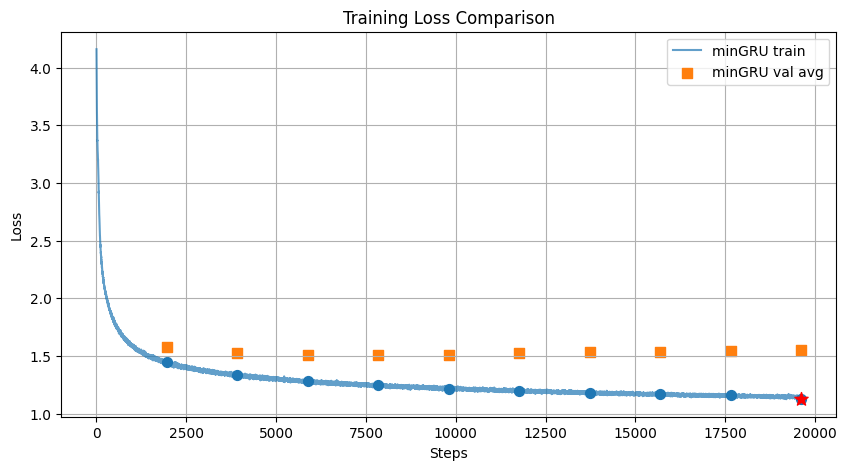

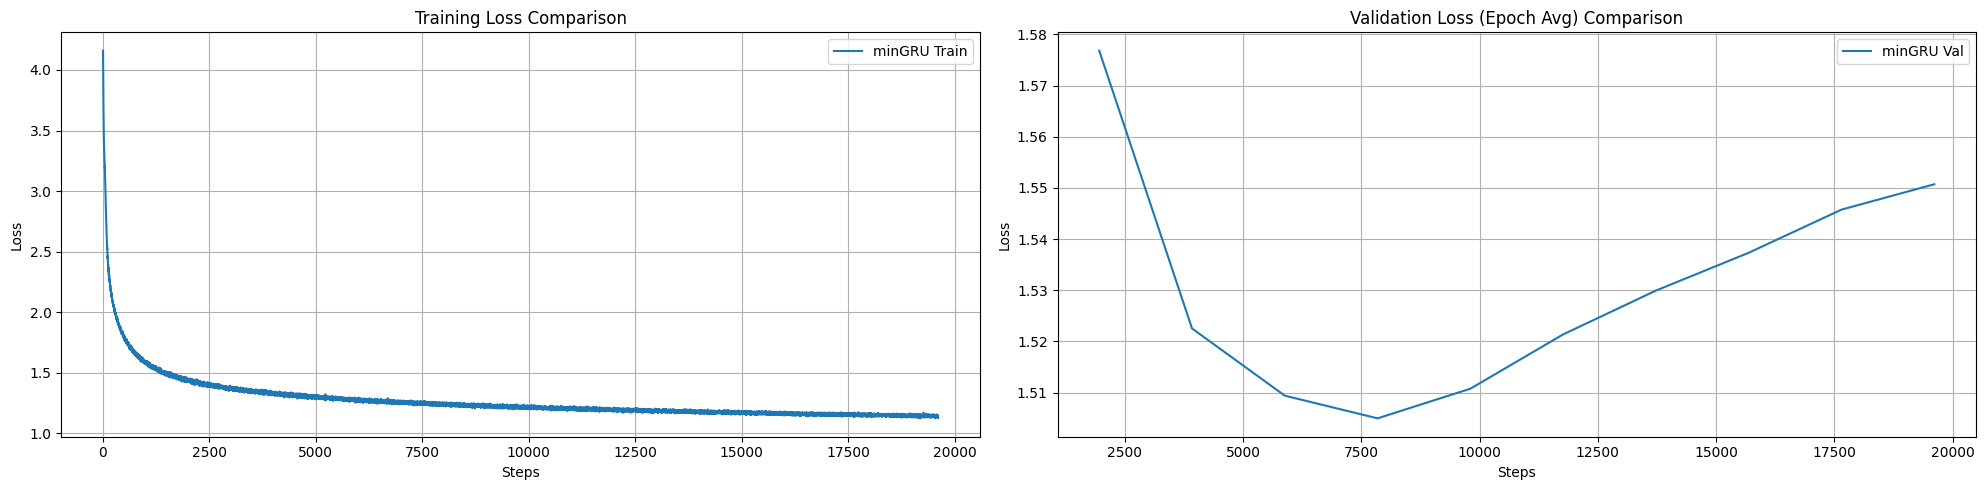

In [25]:
train_and_test("minGRU", mingru, start_text)

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import abc
from typing import Final, List, Tuple, Optional, Union


from torch.nn import RMSNorm

class CausalDepthWiseConv1d(nn.Module):
    # 인과적(Causal) 1D Depth-wise 컨볼루션
    def __init__(self, dim, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.net = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim), # Depthwise
            nn.Conv1d(dim, dim, kernel_size=1)                       # Pointwise
        )
    def forward(self, x): # 입력: (B, L, C)
        x_transposed = x.transpose(1, 2) # (B, C, L)
        x_padded = F.pad(x_transposed, (self.kernel_size - 1, 0))
        x_out = self.net(x_padded)
        return x_out.transpose(1, 2) # 출력: (B, L, C)


# --- MinGRU 핵심 기능 (mF 네임스페이스) ---
class mF:
    @staticmethod
    def g(x: torch.Tensor) -> torch.Tensor:
        out = torch.empty_like(x)
        mask = x >= 0
        out[mask] = x[mask] + torch.tensor(0.5, dtype=x.dtype, device=x.device)
        out[~mask] = torch.sigmoid(x[~mask])
        return out

    @staticmethod
    def log_g(x: torch.Tensor) -> torch.Tensor:
        out = torch.empty_like(x)
        mask = x >= 0
        out[mask] = (x[mask] + torch.tensor(0.5, dtype=x.dtype, device=x.device)).log().to(x.dtype)
        out[~mask] = (-F.softplus(-x[~mask])).to(x.dtype)
        return out

    @staticmethod
    def _parallel_scan_log(log_a: torch.Tensor, log_b: torch.Tensor) -> torch.Tensor:
        pad_dims = [0] * (log_a.ndim - 2) * 2 + [1, 0]
        a_star = F.pad(torch.cumsum(log_a, dim=1), pad_dims)
        x0_plus_b_star = torch.logcumsumexp(log_b - a_star, dim=1)
        
        log_x = a_star + x0_plus_b_star
        return torch.exp(log_x)

    @staticmethod
    def _mingru_parallel(h_prev_log: torch.Tensor, gate: torch.Tensor, hidden: torch.Tensor) -> torch.Tensor:
        log_z = -F.softplus(-gate)
        log_one_minus_z = -F.softplus(gate)
        log_tilde_h = mF.log_g(hidden)
        log_b_for_scan = torch.cat((h_prev_log, log_z + log_tilde_h), dim=1)
        h_sequence_plus_initial = mF._parallel_scan_log(log_one_minus_z, log_b_for_scan)
        return h_sequence_plus_initial[:, 1:]

    @staticmethod
    def mingru_gate_hidden(gate: torch.Tensor, hidden: torch.Tensor, h_prev: torch.Tensor) -> torch.Tensor:
        epsilon = torch.tensor(1e-12, dtype=h_prev.dtype, device=h_prev.device)
        log_h_prev = (h_prev + epsilon).log()
        return mF._mingru_parallel(log_h_prev, gate, hidden)


class MinGRU(nn.Module): # MinGRUBase 대신 nn.Module 직접 상속 
    layer_sizes: Tuple[int, ...] # Final 제거 (JIT 호환성)
    num_layers: int # Final 제거

    def __init__(
        self,
        input_size: int,
        hidden_sizes: List[int],
        bias: bool = True, # 명시적 파라미터 (기존 * 제거)
        norm: bool = False,
        dropout: float = 0.0,
        residual: bool = False,
    ):
        super().__init__()
        self.layer_sizes = tuple([input_size] + hidden_sizes)
        self.num_layers = len(hidden_sizes)
        self.dropout_p = dropout
        self.residual = residual
        self.use_internal_norm = norm
        
        layers_list = [] # ModuleList 사용
        gen = zip(self.layer_sizes[:-1], self.layer_sizes[1:])
        for lidx, (ind, outd) in enumerate(gen):
            layer_modules = {} # 일반 dict 사용
            if self.use_internal_norm:
                layer_modules["norm"] = torch.nn.LayerNorm(ind)
            else:
                layer_modules["norm"] = torch.nn.Identity()

            layer_modules["gate_hidden"] = torch.nn.Linear(ind, outd * 2, bias=bias)
            layer_modules["res_align"] = torch.nn.Linear(ind, outd, bias=False) if residual and ind != outd else torch.nn.Identity()
            layer_modules["dropout"] = torch.nn.Dropout(p=self.dropout_p) if self.dropout_p > 0.0 and lidx < (self.num_layers - 1) else torch.nn.Identity()
            layers_list.append(torch.nn.ModuleDict(layer_modules)) # ModuleDict를 리스트에 추가
        self.layers = torch.nn.ModuleList(layers_list) # ModuleList로 변환


    def init_hidden_state(self, x: torch.Tensor) -> List[torch.Tensor]:
        return [mF.g(x.new_zeros(x.shape[0], 1, hs, dtype=x.dtype)) for hs in self.layer_sizes[1:]]

    def forward(
        self,
        x: torch.Tensor,
        h: Optional[List[torch.Tensor]] = None,
    ) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        if h is None: h = self.init_hidden_state(x)
        
        inp = x
        next_hidden_states: List[torch.Tensor] = [] # 타입 명시
        for lidx in range(self.num_layers): # ModuleList는 직접 인덱싱 또는 이터레이션
            layer_module_dict = self.layers[lidx]
            norm_out = layer_module_dict["norm"](inp)
            gate, hidden = layer_module_dict["gate_hidden"](norm_out).chunk(2, dim=2)
            
            current_h: torch.Tensor = h[lidx] # 타입 명시
            out_sequence = mF.mingru_gate_hidden(gate, hidden, current_h)
            next_hidden_states.append(out_sequence[:, -1:])
            
            if self.residual:
                out_sequence = out_sequence + layer_module_dict["res_align"](inp)
            inp = layer_module_dict["dropout"](out_sequence)
        return inp, next_hidden_states


class SwiGLUFFN(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 2.0, dropout: float = 0.0):
        super().__init__()
        hidden_dim = int(dim * expansion_factor * (2/3))
        hidden_dim = (hidden_dim + 7) // 8 * 8
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(dim, hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.act_fn = nn.SiLU()
    def forward(self, x):
        return self.dropout(self.w3(self.act_fn(self.w1(x)) * self.w2(x)))

class MinGRUDecoder2(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: Union[int, List[int]],
        num_layers: Optional[int] = None,
        dropout: float = 0.1,
        rms_norm_eps: float = 1e-8,
        enable_conv: bool = True,
        conv_kernel_size: int = 3,
        ffn_expansion_factor: float = 1.0
    ):
        super().__init__()
        
        if isinstance(hidden_dim, int):
            if num_layers is None or num_layers < 1: raise ValueError("`num_layers`는 양의 정수여야 합니다.")
            mingru_internal_sizes = [hidden_dim] * num_layers
        elif isinstance(hidden_dim, list):
            if not hidden_dim: raise ValueError("`hidden_dim` 리스트는 비어있을 수 없습니다.")
            mingru_internal_sizes = hidden_dim
        else:
            raise TypeError("`hidden_dim`은 정수 또는 정수 리스트여야 합니다.")
        
        mingru_input_dim = mingru_internal_sizes[0]
        mingru_output_dim = mingru_internal_sizes[-1]
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.input_projection = nn.Linear(embedding_dim, mingru_input_dim) if embedding_dim != mingru_input_dim else nn.Identity()
        self.conv_block = CausalDepthWiseConv1d(mingru_input_dim, conv_kernel_size) if enable_conv else nn.Identity()
        
        self.norm_pre_gru = RMSNorm(mingru_input_dim, eps=rms_norm_eps)
        
        self.mingru_module = MinGRU(
            input_size=mingru_input_dim,
            hidden_sizes=mingru_internal_sizes,
            # norm=False, # MinGRU 내부 LayerNorm 비활성화 (외부 RMSNorm 사용)
            dropout=dropout, 
            residual=True
        )
        self.gru_residual_projection = nn.Linear(mingru_input_dim, mingru_output_dim) if mingru_input_dim != mingru_output_dim else nn.Identity()

        self.norm_post_gru = RMSNorm(mingru_output_dim, eps=rms_norm_eps)
        self.ffn_module = SwiGLUFFN(dim=mingru_output_dim, expansion_factor=ffn_expansion_factor, dropout=dropout)
        self.final_norm = RMSNorm(mingru_output_dim, eps=rms_norm_eps)
        self.output_projection = nn.Linear(mingru_output_dim, vocab_size)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, None]:
        h = self.input_projection(self.embedding(x))
        
        h_res_conv = h
        if not isinstance(self.conv_block, nn.Identity): # nn.Identity가 아닐 때만 연산
            h = h_res_conv + self.conv_block(h_res_conv)

        h_res_gru = h
        h_gru_input = self.norm_pre_gru(h_res_gru)
        h_gru_out, _ = self.mingru_module(h_gru_input)
        h = self.gru_residual_projection(h_res_gru) + h_gru_out

        h_res_ffn = h
        h_ffn_input = self.norm_post_gru(h_res_ffn)
        h = h_res_ffn + self.ffn_module(h_ffn_input)
        
        h_final = self.final_norm(h)
        logits = self.output_projection(h_final)
        
        return logits, None

In [27]:
### Model Initialization
mingru2 = MinGRUDecoder2(vocab_size, EMBEDDING_DIM, 316, NUM_LAYERS).to(device)

In [28]:
from torchinfo import summary

summary(mingru2, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
MinGRUDecoder2                           [512, 128, 65]            --
├─Embedding: 1-1                         [512, 128, 128]           8,320
├─Linear: 1-2                            [512, 128, 316]           40,764
├─CausalDepthWiseConv1d: 1-3             [512, 128, 316]           --
│    └─Sequential: 2-1                   [512, 316, 128]           --
│    │    └─Conv1d: 3-1                  [512, 316, 128]           1,264
│    │    └─Conv1d: 3-2                  [512, 316, 128]           100,172
├─RMSNorm: 1-4                           [512, 128, 316]           316
├─MinGRU: 1-5                            [512, 128, 316]           --
│    └─ModuleList: 2-2                   --                        --
│    │    └─ModuleDict: 3-3              --                        200,344
│    │    └─ModuleDict: 3-4              --                        200,344
│    │    └─ModuleDict: 3-5              --                

In [ ]:
train_and_test("minGRU2", mingru2, start_text)

Epoch 1/10, Train Loss: 1.5098, Val Loss: 1.6943, Epoch Time: 240.08s Average Vram Usage: 48.19MB


Epoch 2/10, Train Loss: 1.3869, Val Loss: 1.6318, Epoch Time: 239.93s Average Vram Usage: 48.22MB


Epoch 3/10, Train Loss: 1.2993, Val Loss: 1.5891, Epoch Time: 238.96s Average Vram Usage: 48.22MB


Epoch 4:  92%|█████████▏| 1797/1961 [03:32<00:19,  8.47it/s, loss=1.2717, step=7680, vram=48.05 MB]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Optional, Union


class CausalConv1D(nn.Module):
    """Causal 1D Depthwise Convolution"""
    
    def __init__(self, dim: int, kernel_size: int):
        super().__init__()
        self.kernel_size = kernel_size
        self.depthwise = nn.Conv1d(dim, dim, kernel_size, groups=dim)
        self.pointwise = nn.Conv1d(dim, dim, kernel_size=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, seq_len, dim)
        x = x.transpose(1, 2)  # (batch, dim, seq_len)
        x = F.pad(x, (self.kernel_size - 1, 0))  # causal padding
        x = self.pointwise(self.depthwise(x))
        return x.transpose(1, 2)  # (batch, seq_len, dim)


class MinGRUFunctions:
    """MinGRU core mathematical functions"""
    
    @staticmethod
    def g_activation(x: torch.Tensor) -> torch.Tensor:
        """Custom activation function"""
        positive_mask = x >= 0
        result = torch.empty_like(x)
        result[positive_mask] = x[positive_mask] + 0.5
        result[~positive_mask] = torch.sigmoid(x[~positive_mask])
        return result
    
    @staticmethod
    def log_g_activation(x: torch.Tensor) -> torch.Tensor:
        """Log version of g activation"""
        positive_mask = x >= 0
        result = torch.empty_like(x)
        result[positive_mask] = torch.log(x[positive_mask] + 0.5)
        result[~positive_mask] = -F.softplus(-x[~positive_mask])
        return result
    
    @staticmethod
    def parallel_scan(log_gates: torch.Tensor, log_values: torch.Tensor) -> torch.Tensor:
        """Parallel scan operation for efficient sequence processing"""
        # Cumulative sum of log gates
        cumsum_gates = F.pad(torch.cumsum(log_gates, dim=1), [1, 0])
        
        # Log-cumsum-exp operation
        adjusted_values = log_values - cumsum_gates
        cumsum_values = torch.logcumsumexp(adjusted_values, dim=1)
        
        # Combine results
        log_output = cumsum_gates + cumsum_values
        return torch.exp(log_output)
    
    @staticmethod
    def mingru_step(gate: torch.Tensor, hidden: torch.Tensor, prev_state: torch.Tensor) -> torch.Tensor:
        """Single MinGRU computation step"""
        eps = 1e-12
        log_prev = torch.log(prev_state + eps)
        
        # Compute log probabilities
        log_forget = -F.softplus(gate)  # log(1 - sigmoid(gate))
        log_update = -F.softplus(-gate)  # log(sigmoid(gate))
        log_candidate = MinGRUFunctions.log_g_activation(hidden)
        
        # Combine initial state and sequence
        log_states = torch.cat([log_prev, log_update + log_candidate], dim=1)
        
        # Apply parallel scan
        sequence_output = MinGRUFunctions.parallel_scan(log_forget, log_states)
        return sequence_output[:, 1:]  # Remove initial state


class MinGRULayer(nn.Module):
    """Single MinGRU layer"""
    
    def __init__(self, input_dim: int, hidden_dim: int, use_bias: bool = True):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.gate_projection = nn.Linear(input_dim, hidden_dim * 2, bias=use_bias)
        self.residual_projection = nn.Linear(input_dim, hidden_dim, bias=False) if input_dim != hidden_dim else nn.Identity()
    
    def forward(self, x: torch.Tensor, prev_state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Project input to gate and hidden
        gate_hidden = self.gate_projection(x)
        gate, hidden = gate_hidden.chunk(2, dim=-1)
        
        # Apply MinGRU computation
        output = MinGRUFunctions.mingru_step(gate, hidden, prev_state)
        
        # Residual connection
        if not isinstance(self.residual_projection, nn.Identity):
            output = output + self.residual_projection(x)
        
        # Return output and last hidden state
        next_state = output[:, -1:, :]
        return output, next_state


class MinGRU(nn.Module):
    """Multi-layer MinGRU"""
    
    def __init__(self, input_dim: int, hidden_dims: List[int], dropout: float = 0.0):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.num_layers = len(hidden_dims)
        
        # Build layers
        layer_dims = [input_dim] + hidden_dims
        self.layers = nn.ModuleList([
            MinGRULayer(layer_dims[i], layer_dims[i + 1])
            for i in range(self.num_layers)
        ])
        
        # Dropout (except for last layer)
        self.dropouts = nn.ModuleList([
            nn.Dropout(dropout) if i < self.num_layers - 1 else nn.Identity()
            for i in range(self.num_layers)
        ])
    
    def init_states(self, batch_size: int, device: torch.device) -> List[torch.Tensor]:
        """Initialize hidden states"""
        return [
            MinGRUFunctions.g_activation(torch.zeros(batch_size, 1, dim, device=device))
            for dim in self.hidden_dims
        ]
    
    def forward(self, x: torch.Tensor, states: Optional[List[torch.Tensor]] = None) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        if states is None:
            states = self.init_states(x.size(0), x.device)
        
        output = x
        next_states = []
        
        for i, (layer, dropout) in enumerate(zip(self.layers, self.dropouts)):
            output, next_state = layer(output, states[i])
            output = dropout(output)
            next_states.append(next_state)
        
        return output, next_states


class SwiGLU(nn.Module):
    """SwiGLU Feed-Forward Network"""
    
    def __init__(self, dim: int, expansion_factor: float = 2.0, dropout: float = 0.0):
        super().__init__()
        hidden_dim = int(dim * expansion_factor * 2/3)
        hidden_dim = ((hidden_dim + 7) // 8) * 8  # Round to multiple of 8
        
        self.gate_proj = nn.Linear(dim, hidden_dim, bias=False)
        self.up_proj = nn.Linear(dim, hidden_dim, bias=False)
        self.down_proj = nn.Linear(hidden_dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.SiLU()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        gate = self.activation(self.gate_proj(x))
        up = self.up_proj(x)
        return self.dropout(self.down_proj(gate * up))


class MinGRUDecoder3(nn.Module):
    """Complete MinGRU-based decoder model"""
    
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        hidden_dims: Union[int, List[int]],
        num_layers: Optional[int] = None,
        dropout: float = 0.1,
        use_conv: bool = True,
        conv_kernel: int = 3,
        ffn_expansion: float = 1.0,
        norm_eps: float = 1e-8,
    ):
        super().__init__()
        
        # Handle hidden dimensions
        if isinstance(hidden_dims, int):
            if num_layers is None:
                raise ValueError("num_layers must be specified when hidden_dims is int")
            hidden_dims = [hidden_dims] * num_layers
        
        self.embed_dim = embed_dim
        self.hidden_dims = hidden_dims
        
        # Input layers
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.input_proj = nn.Linear(embed_dim, hidden_dims[0]) if embed_dim != hidden_dims[0] else nn.Identity()
        
        # Optional convolution
        self.conv = CausalConv1D(hidden_dims[0], conv_kernel) if use_conv else None
        
        # Core MinGRU
        self.pre_gru_norm = nn.RMSNorm(hidden_dims[0], eps=norm_eps)
        self.mingru = MinGRU(hidden_dims[0], hidden_dims, dropout)
        
        # Feed-forward network
        self.post_gru_norm = nn.RMSNorm(hidden_dims[-1], eps=norm_eps)
        self.ffn = SwiGLU(hidden_dims[-1], ffn_expansion, dropout)
        
        # Output layers
        self.final_norm = nn.RMSNorm(hidden_dims[-1], eps=norm_eps)
        self.output_proj = nn.Linear(hidden_dims[-1], vocab_size)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Embedding and input projection
        h = self.embedding(x)
        h = self.input_proj(h)
        
        # Optional convolution with residual
        if self.conv is not None:
            h = h + self.conv(h)
        
        # MinGRU processing
        h_norm = self.pre_gru_norm(h)
        gru_out, _ = self.mingru(h_norm)
        h = h + gru_out  # Residual connection
        
        # Feed-forward with residual
        h_norm = self.post_gru_norm(h)
        ffn_out = self.ffn(h_norm)
        h = h + ffn_out  # Residual connection
        
        # Final output
        h = self.final_norm(h)
        logits = self.output_proj(h)
        
        return logits, _


In [ ]:
### Model Initialization
mingru3 = MinGRUDecoder3(vocab_size, EMBEDDING_DIM, 316, NUM_LAYERS).to(device)

In [ ]:
from torchinfo import summary

summary(mingru3, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

In [ ]:
train_and_test("minGRU3", mingru3, start_text)